# Introduction
This notebook is a re-implementation of [DiffEdit as outlined in the research paper](https://arxiv.org/abs/2210.11427) on arxiv. 

# Setup

In [48]:
!pip install -Uq diffusers transformers fastcore

In [49]:
from tqdm.auto import tqdm

import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Import SD specific libraries and functions

In [50]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [51]:
from diffusers import AutoencoderKL, UNet2DConditionModel

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [52]:
from diffusers import LMSDiscreteScheduler, DDIMScheduler

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)
#scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

## Define SD functions

In [53]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

def img2latent(img):
  # convert image back to latent
  with torch.no_grad():
    latent = vae.encode(img.unsqueeze(0).to("cuda").half())
    latent = 0.18215 * latent.latent_dist.sample()

  return latent

def latent2img(latent):
  with torch.no_grad():         
    latent = (1 / 0.18215) * latent
    image = vae.decode(latent).sample     
    image = (image / 2 + 0.5).clamp(0, 1).squeeze(0)

  return image

# Make starting image

In [76]:
prompts = [
    'a photo of a horse on a sheet of ice'
]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [77]:
images = mk_samples(prompts)

<ipython-input-53-004bef0901c8>:17: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

In [78]:
image = images[0]

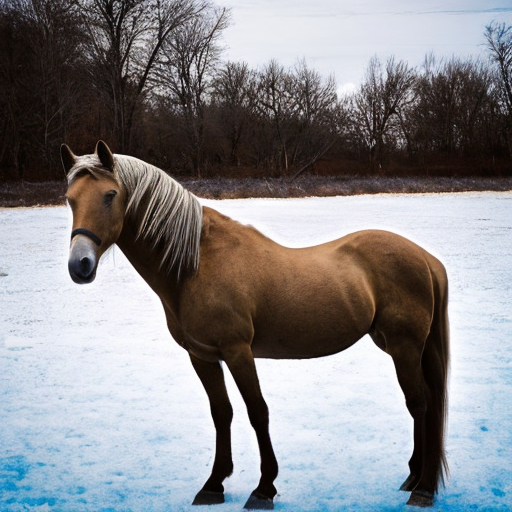

In [79]:
#from IPython.display import display

display(mk_img(images[0]))

# DiffEdit Algorithm
## Step 1: Compute mask
1. Add Gaussian noise of strength 0.5 to image
2. Calculate predicted noise in image using query and reference text
3. Repeat steps 1 and 2 for 10 times to get normalised difference
4. Binarise to get mask

In [80]:
# play around with `timestep` to see what value is best 
sample_timestep = 60
t = scheduler.timesteps[sample_timestep] 

In [81]:
reference = ['a photo of a horse on a sheet of ice']
query = ['a photo of a zebra on a sheet of ice']

ref_emb = text_enc(reference)
query_emb = text_enc(query)

In [82]:
strength = 0.5
def add_gaussian_noise(image, strength=strength):
  # Calculate the dynamic range of the image
  max_value = torch.max(image)
  min_value = torch.min(image)

  # Calculate the standard deviation of the noise
  std_dev = strength * (max_value - min_value) / 2

  # Generate random Gaussian noise tensor with the same shape as the input image
  noise = torch.randn_like(image) * std_dev

  # Add the noise to the original image
  noisy_image = image + noise

  return noisy_image

In [83]:
def pred_noise_residual(latent, t, condition_emb):
  with torch.no_grad(): 
    pred = unet(latent, t, encoder_hidden_states=condition_emb).sample

  return pred

In [84]:
latent = img2latent(image)
noise = pred_noise_residual(latent, t, ref_emb)

latent_diff = torch.zeros(noise.shape).to("cuda")

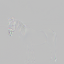

In [85]:
for i in range(10):
  noisy_img = add_gaussian_noise(image)
  latent = img2latent(noisy_img)
  ref_noise= pred_noise_residual(latent, t, ref_emb)
  query_noise= pred_noise_residual(latent, t, query_emb)

  latent_diff += ref_noise-query_noise

latent_diff /= 10 # average across a set of 10 input noises

display(mk_img(latent_diff.squeeze(0)))

In [86]:
# rescale values in diff_tensor to be [0, 1]
min_val = torch.min(latent_diff) 
max_val = torch.max(latent_diff)

# Rescale the tensor values between 0 and 1
rescaled_latent_diff = torch.div(latent_diff - min_val, max_val - min_val)

In [87]:
# binarise rescaled_tensor
threshold = 0.5

# Binarize the tensor using the threshold
binary_tensor = torch.where(rescaled_latent_diff >= threshold, torch.tensor(1), torch.tensor(0))
binary_tensor.shape

torch.Size([1, 4, 64, 64])

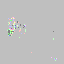

In [88]:
display(mk_img(binary_tensor.squeeze(0)))

In [89]:
mask = binary_tensor
not_mask = torch.logical_not(mask).to(torch.device("cuda"))

## Step 2: Encoding with DDIM until we get the noise


In [90]:
init_timestep = 35
print(init_timestep)

35


In [91]:
latent = img2latent(image)
noise = torch.randn_like(latent).to("cuda").half()

timesteps = torch.tensor([scheduler.timesteps[-init_timestep]], device="cuda")
noisy_latent = scheduler.add_noise(latent, noise, timesteps=timesteps)

In [92]:
noisy_img = latent2img(noisy_latent)

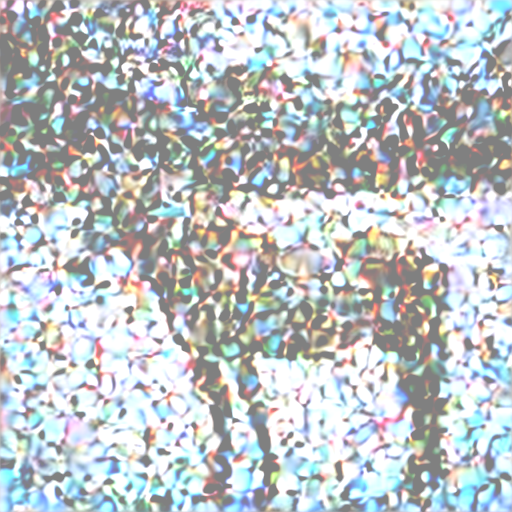

In [93]:
display(mk_img(noisy_img))

## Step 3: Decode with mask-wise correction
1. Using `noisy_latent` as a starting point, we start denoising it using the standard stable diffusion process. However, we use the 2 prompts (reference and query) to do the denoising.

In [107]:
# decide on the timesteps to take
g = 7.5

continue_timestep = max(num_inference_steps-init_timestep, 0)
print(continue_timestep)
timesteps = scheduler.timesteps[continue_timestep:].to("cuda")

emb = torch.cat([ref_emb, query_emb])

latents = noisy_latent

for i,ts in enumerate(tqdm(timesteps)):
  inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
  with torch.no_grad(): r, q = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
  pred = (torch.mul(mask, q) + torch.mul(not_mask, r)) + g * (q - r)
  latents = scheduler.step(pred, ts, latents).prev_sample


35


  0%|          | 0/35 [00:00<?, ?it/s]

In [108]:
diffedit_img = latent2img(latents)

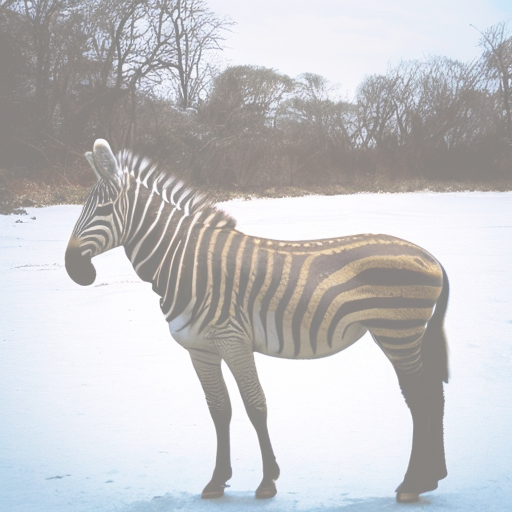

In [109]:
display(mk_img(diffedit_img))